## 自己编写get_perspective_transform

In [1]:
import torch

def get_perspective_transform(src, dst):
    """
    计算透视变换矩阵
    :param src: 源点坐标，shape为(n, 2)，n为点数
    :param dst: 目标点坐标，shape为(n, 2)，n为点数
    :return: 透视变换矩阵，shape为(3, 3)
    """
    assert src.shape == dst.shape and src.shape[0] >= 4, "源点坐标和目标点坐标的shape应相等且均>=4"
    n = src.shape[0]

    A = torch.zeros((n*2, 8), dtype=torch.float32)
    B = torch.zeros((n*2,), dtype=torch.float32)

    for i in range(n):
        A[i*2, :] = torch.tensor([src[i][0], src[i][1], 1, 0, 0, 0, -src[i][0]*dst[i][0], -src[i][1]*dst[i][0]], dtype=torch.float32)
        A[i*2+1, :] = torch.tensor([0, 0, 0, src[i][0], src[i][1], 1, -src[i][0]*dst[i][1], -src[i][1]*dst[i][1]], dtype=torch.float32)
        B[i*2] = dst[i][0]
        B[i*2+1] = dst[i][1]

    H = torch.linalg.solve(A, B)
    H = torch.cat((H,torch.ones(1)),dim=0).reshape(3, 3)

    return H

In [2]:
src_points = torch.tensor([[0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0]])
dst_points = torch.tensor([[-2.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 2.0]])
src = src_points.numpy()
dist = dst_points.numpy()

import cv2 
cv2.getPerspectiveTransform(src,dist),get_perspective_transform(src_points, dst_points)

(array([[ 6.,  2., -2.],
        [ 0.,  6.,  0.],
        [ 3.,  2.,  1.]]),
 tensor([[ 6.,  2., -2.],
         [ 0.,  6.,  0.],
         [ 3.,  2.,  1.]]))

In [3]:
four_point_org = torch.zeros((2, 2, 2))
four_point_org[:, 0, 0] = torch.Tensor([0, 0])
four_point_org[:, 0, 1] = torch.Tensor([128 - 1, 0])
four_point_org[:, 1, 0] = torch.Tensor([0, 128 - 1])
four_point_org[:, 1, 1] = torch.Tensor([128 - 1, 128 - 1])
four_point_org.flatten(1).permute(1, 0).unsqueeze(0)

tensor([[[  0.,   0.],
         [127.,   0.],
         [  0., 127.],
         [127., 127.]]])

## 测试IHN代码(CVUSA-20)
- 修改tgm.get_perspective_transform()源码 
- X, LU = torch.gesv(b, A)   ===>   X = torch.linalg.solve(A, b)

- 设置参数

In [4]:
import numpy as np
import os
import torch
import argparse
from network import IHN
from utils import *
import datasets_4cor_img as datasets
import scipy.io as io
import torchvision
import numpy as np
import time
setup_seed(2022)

parser = argparse.ArgumentParser()
parser.add_argument('--model', default='results/moveobj_lev1/IHN.pth',help="restore checkpoint")
parser.add_argument('--iters_lev0', type=int, default=26)
parser.add_argument('--iters_lev1', type=int, default=26)
parser.add_argument('--mixed_precision', default=False, action='store_true',
                    help='use mixed precision')
parser.add_argument('--dropout', type=float, default=0.0)
parser.add_argument('--gpuid', type=int, nargs='+', default=[0])
parser.add_argument('--savemat', type=str,  default='mscoco.mat')
parser.add_argument('--savedict', type=str, default='mscoco.npy')
parser.add_argument('--dataset', type=str, default='mscoco', help='dataset')    
parser.add_argument('--lev0', default=True, action='store_true',
                    help='warp no')
parser.add_argument('--lev1', default=True, action='store_true',
                    help='warp once')
parser.add_argument('--weight', default=False, action='store_true',
                    help='weight')
parser.add_argument('--model_name_lev0', default='', help='specify model0 name')
parser.add_argument('--model_name_lev1', default='', help='specify model0 name')

args = parser.parse_args([]) # '--model', 'results/moveobj/IHN.pth'

- 读入模型与数据

In [5]:
device = torch.device('cuda:'+ str(args.gpuid[0]))

model = IHN(args)
model_med = torch.load(args.model, map_location='cuda:0')
model.load_state_dict(model_med)

model.to(device) 
model.eval()

batchsz = 1

- 读入卫星图数据

In [6]:
idx = 111#737

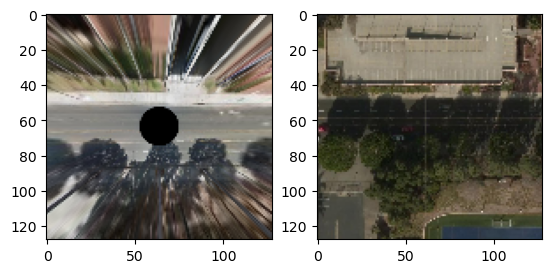

In [7]:
# 读入卫星图数据
import cv2
import matplotlib.pyplot as plt
img_path1 = "/home/wxl/Data/CVUSA/bingmap/20/{:07}.jpg".format(idx)
img_path0 = '/home/wxl/Data/CVUSA/BEV/pano/{:07}.png'.format(idx)
img1 = cv2.imread(img_path0)[:,:,::-1]
img2 = cv2.imread(img_path1)[:,:,::-1]
# img2 = img1[100:228, 150:278]
h2,w2,_ = img2.shape
# tl_y, tl_x, br_y,br_x = 375-250,375-200,375+250,375+150
tl_y, tl_x, br_y,br_x = 375-375,375-375,375+375,375+375
corners0 = np.array([[tl_x, tl_y], [tl_x, br_y], [br_x, tl_y], [br_x, br_y]], dtype=np.float32)
img2_ = img2[tl_y:br_y, tl_x:br_x]
h1,w1,_ = img1.shape
h2,w2,_ = img2.shape
corners1 = np.array([[0, 0], [0, h1], [w1, 0], [w1, h1]], dtype=np.float32)
corners2 = np.array([[0, 0], [0, h2], [w2, 0], [w2, h2]], dtype=np.float32)
corners_128 = np.array([[0, 0], [0, 128], [128, 0], [128, 128]], dtype=np.float32)
H0 = cv2.getPerspectiveTransform(corners0, corners2)
H1 = cv2.getPerspectiveTransform(corners1, corners_128)
H2 = cv2.getPerspectiveTransform(corners2, corners_128)
img1_ = cv2.resize(img1, (128, 128))
img2_ = cv2.resize(img2_, (128, 128))
plt.subplot(1,2,1)
plt.imshow(img1_)
plt.subplot(1,2,2)
plt.imshow(img2_)
img1_ = torch.from_numpy((img1_)).float().permute(2, 0, 1).unsqueeze(0)
img2_ = torch.from_numpy((img2_)).float().permute(2, 0, 1).unsqueeze(0)

- 网络模型预测

In [8]:
# 网络模型预测
import time
img1_ = img1_.to(model.device)
img2_ = img2_.to(model.device)
start = time.time()
four_pred = model(img1_, img2_, iters_lev0=args.iters_lev0, iters_lev1=args.iters_lev1, test_mode=True)
print(1000*(time.time() - start))

# flow_4cor = torch.zeros((four_pred.shape[0], 2, 2, 2))
# flow_4cor[:, :, 0, 0] = flow_gt[:, :, 0, 0]
# flow_4cor[:, :, 0, 1] = flow_gt[:, :, 0, -1]
# flow_4cor[:, :, 1, 0] = flow_gt[:, :, -1, 0]
# flow_4cor[:, :, 1, 1] = flow_gt[:, :, -1, -1]
# mace_ = (flow_4cor - four_pred.cpu().detach())**2
# mace_ = ((mace_[:,0,:,:] + mace_[:,1,:,:])**0.5)
# mace_vec = torch.mean(torch.mean(mace_, dim=1), dim=1)
# four_pred.shape,four_pred, flow_4cor,mace_, mace_.shape, mace_vec

/home/wxl/anaconda3/envs/torch/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642991888/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/wxl/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:4070: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


1751.6748905181885


- 计算单应矩阵

In [9]:
# 计算单应矩阵
import torchgeometry as tgm
four_point_org = torch.zeros((2, 2, 2)).to(four_pred.device)
four_point_org[:, 0, 0] = torch.Tensor([0, 0])
four_point_org[:, 0, 1] = torch.Tensor([127, 0])
four_point_org[:, 1, 0] = torch.Tensor([0, 127])
four_point_org[:, 1, 1] = torch.Tensor([127, 127])
four_point_new = four_point_org + four_pred.squeeze(0)
H = tgm.get_perspective_transform(four_point_org.unsqueeze(0).flatten(2).permute(0,2,1), four_point_new.unsqueeze(0).flatten(2).permute(0,2,1))
H = H[0].detach().cpu().numpy()
H_ = np.linalg.inv(H0).dot(np.linalg.inv(H2)).dot(H).dot(H1)

- 显示输出

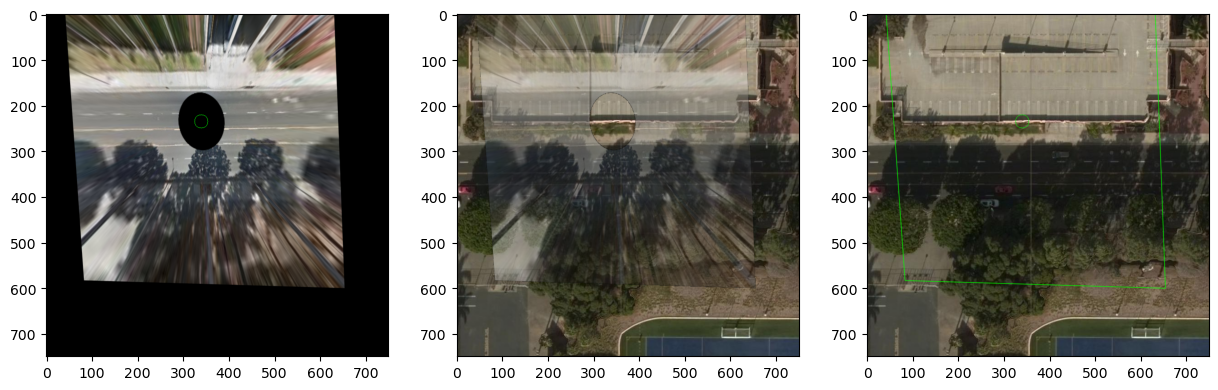

In [10]:
plt.figure(figsize=(15,5))
# plt.tight_layout()
result = show_overlap(img1, img2, H_)
# plt.figure(figsize=(20,5))
# plt.imshow(result/255)

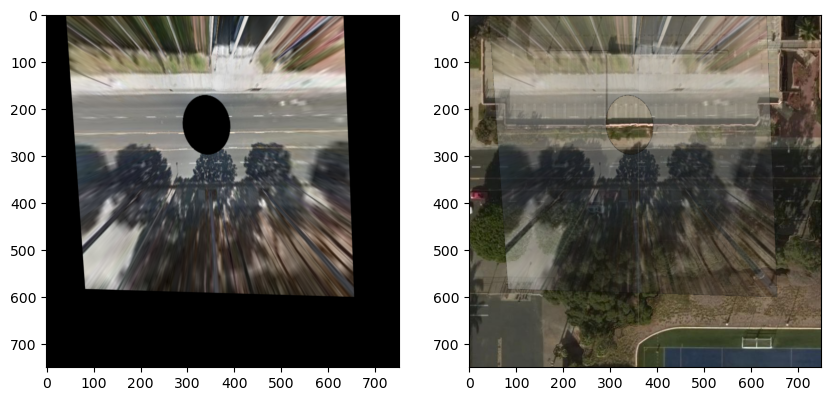

In [11]:
# 显示重叠
# image1 = img1[0].permute(1, 2,0).detach().cpu().numpy()
# image0 = img2[0].permute(1, 2,0).detach().cpu().numpy()
image1 = img1
image0 = img2
result = cv2.warpPerspective(image1, H_, (image0.shape[1] + image1.shape[1], image0.shape[0]))
h,w = image0.shape[0],image0.shape[1]
mask_temp =result[:,0:w] > 1

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(result[:,0:w].astype(np.uint8),cmap='gray')

temp = image0
# temp = np.zeros((result[:,0:w].shape[0],result[:,0:w].shape[1],3))
# for i in range(3):
#     temp[:,:,i] = image0[:,:]
# 
temp2 = np.zeros((result[:,0:w].shape[0],result[:,0:w].shape[1],3))
temp2[:,:,:] = result[:,0:w,:]
# for i in range(3):
    # temp2[:,:,i] = result[:,0:w]
frame = temp.astype(np.uint8)
roi = frame[mask_temp]
frame[mask_temp] = (0.5*temp2.astype(np.uint8)[mask_temp] + 0.5 * roi).astype(np.uint8)
plt.subplot(1,2,2)
plt.imshow(frame)

# plt.subplot(1,2,1)
# warped_image = cv2.warpPerspective(img1[0].permute(1, 2,0).detach().cpu().numpy()/255, H, (img1.shape[2], img1.shape[3]))
# plt.imshow(warped_image)
# plt.subplot(1,2,2)
# plt.imshow(img2[0].permute(1, 2,0).detach().cpu().numpy()/255)

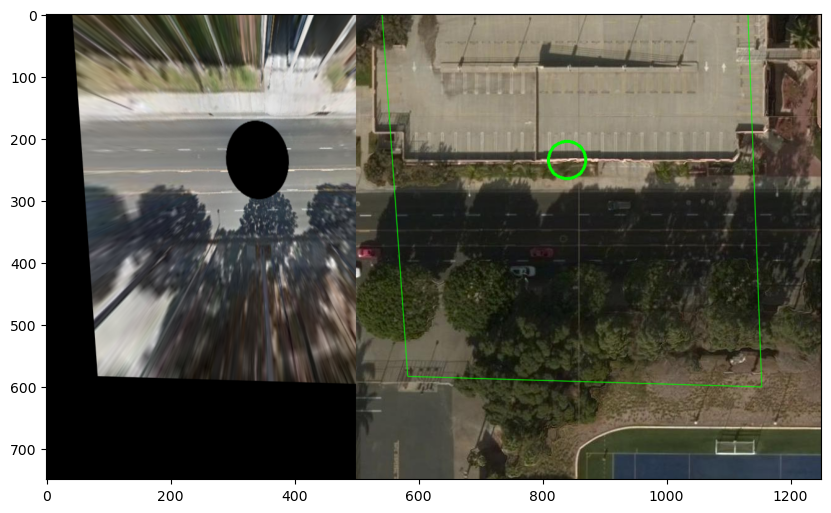

In [12]:
result[0:image0.shape[0],image1.shape[1]:image0.shape[1] + image1.shape[1]] = image0 
h,w = image1.shape[0],image1.shape[1]
pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
center = np.float32( [w/2, h/2]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, H_).reshape(-1, 2)
dst_center = cv2.perspectiveTransform(center, H_).reshape(-1, 2)
# 加上偏移量
for i in range(4):
    dst[i][0] += w
dst_center[0][0] += w

cv2.polylines(result, [np.int32(dst)], True, (0, 255, 0), 1, cv2.LINE_AA)
cv2.circle(result,(int(dst_center[0][0]),int(dst_center[0][1])),30,(0,255,0),3)
plt.figure(figsize=(10,10))

plt.imshow(result.astype(np.uint8))

## MSCOCO2017数据集测试IHN

In [1]:
import numpy as np
import os
import torch
import argparse
from network import IHN
from utils import *
import datasets_4cor_img as datasets
import scipy.io as io
import torchvision
import numpy as np
import time
setup_seed(2022)

parser = argparse.ArgumentParser()
parser.add_argument('--model', default='results/mscoco_lev1/IHN.pth',help="restore checkpoint")
parser.add_argument('--iters_lev0', type=int, default=6)
parser.add_argument('--iters_lev1', type=int, default=6)
parser.add_argument('--mixed_precision', default=False, action='store_true',
                    help='use mixed precision')
parser.add_argument('--dropout', type=float, default=0.0)
parser.add_argument('--gpuid', type=int, nargs='+', default=[0])
parser.add_argument('--savemat', type=str,  default='mscoco.mat')
parser.add_argument('--savedict', type=str, default='mscoco.npy')
parser.add_argument('--dataset', type=str, default='mscoco', help='dataset')    
parser.add_argument('--lev0', default=True, action='store_true',
                    help='warp no')
parser.add_argument('--lev1', default=True, action='store_true',
                    help='warp once')
parser.add_argument('--weight', default=False, action='store_true',
                    help='weight')
parser.add_argument('--model_name_lev0', default='', help='specify model0 name')
parser.add_argument('--model_name_lev1', default='', help='specify model0 name')

args = parser.parse_args([]) # '--model', 'results/moveobj/IHN.pth'

- 读入模型与数据

In [2]:
device = torch.device('cuda:'+ str(args.gpuid[0]))

# model = IHN(args)
model = nn.DataParallel(IHN(args), device_ids=args.gpuid)
model_med = torch.load(args.model, map_location='cuda:0')
model.module.load_state_dict(model_med)

model.to(device) 
model.eval()

batchsz = 10
batch_size = 10
args.batch_size = batchsz
val_dataset = datasets.fetch_dataloader(args, split='validation')

data_blob = next(iter(val_dataset))

img1, img2, flow_gt,  H  = [x.to(model.module.device) for x in data_blob]
for i in range(4):
    print(data_blob[i].shape)

torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 2, 128, 128])
torch.Size([10, 3, 3])


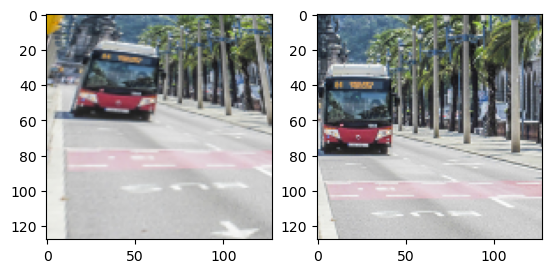

In [3]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(img1[0].permute(1, 2,0).detach().cpu().numpy()/255)
plt.subplot(1,2,2)
plt.imshow(img2[0].permute(1, 2,0).detach().cpu().numpy()/255)

- 自行读入mscoco201数据

In [4]:
# import cv2
# import matplotlib.pyplot as plt
# path = './mscoco2017/test2017/000000002380.jpg'
# img1 = cv2.imread(path)
# img2 = img1[40:228, 40:278]
# img1 = img1[100:210, 150:250]
# img1 = cv2.resize(img1, (128, 128))
# org = np.float32([[0.0, 0.0], [127, 0.0], [0.0, 127], [127,127]])
# dst = np.float32([[-5, 3], [100, 20], [20, 140], [127,127]])
# H_inverse = cv2.getPerspectiveTransform(org, dst)
# img1 = cv2.warpPerspective(img1, H_inverse, (img1.shape[1], img1.shape[0]))
# img2 = cv2.resize(img2, (128, 128))
# plt.subplot(1,2,1)
# plt.imshow(img1)
# plt.subplot(1,2,2)
# plt.imshow(img2)
# img1 = torch.from_numpy((img1)).float().permute(2, 0, 1).unsqueeze(0)
# img2 = torch.from_numpy((img2)).float().permute(2, 0, 1).unsqueeze(0)

In [6]:
# 网络模型预测
import time
t0 = time.time()
img1 = img1.to(model.module.device)
img2 = img2.to(model.module.device)
four_pred = model(img1, img2, iters_lev0=args.iters_lev0, iters_lev1=args.iters_lev1, test_mode=True)
print((time.time()-t0))

flow_4cor = torch.zeros((four_pred.shape[0], 2, 2, 2)).cuda()
flow_4cor[:, :, 0, 0] = flow_gt[:, :, 0, 0]
flow_4cor[:, :, 0, 1] = flow_gt[:, :, 0, -1]
flow_4cor[:, :, 1, 0] = flow_gt[:, :, -1, 0]
flow_4cor[:, :, 1, 1] = flow_gt[:, :, -1, -1]
mace_ = (flow_4cor - four_pred)**2 # dx**2 dy**2
mace_ = ((mace_[:,0,:,:] + mace_[:,1,:,:])**0.5) # 四个角点各自的2范数误差
mace_vec = torch.mean(torch.mean(mace_, dim=1), dim=1) # 8,2,2 shape 数据，求两次均值得到每张图像的误差均值
epe = torch.sum((four_pred - flow_4cor)**2, dim=1).sqrt()
epe.mean().item(), (epe < 1).float().mean().item(), four_pred.shape,mace_.shape, mace_vec # four_pred, flow_4cor,mace_, 

/home/wxl/anaconda3/envs/torch/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642991888/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/wxl/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:4070: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


1.7758691310882568


(0.05197116360068321,
 1.0,
 torch.Size([10, 2, 2, 2]),
 torch.Size([10, 2, 2]),
 tensor([0.0440, 0.0425, 0.0385, 0.0519, 0.0450, 0.0421, 0.0606, 0.0558, 0.0928,
         0.0465], device='cuda:0', grad_fn=<MeanBackward1>))

In [8]:
# 计算单应矩阵
import torchgeometry as tgm
four_point_org = torch.zeros((2, 2, 2)).to(four_pred.device)
four_point_org[:, 0, 0] = torch.Tensor([0, 0])
four_point_org[:, 0, 1] = torch.Tensor([127, 0])
four_point_org[:, 1, 0] = torch.Tensor([0, 127])
four_point_org[:, 1, 1] = torch.Tensor([127, 127])
four_point_org = four_point_org.repeat(four_pred.shape[0], 1, 1, 1)
four_point_new = four_point_org + four_pred
H = tgm.get_perspective_transform(four_point_org.flatten(2).permute(0,2,1), four_point_new.flatten(2).permute(0,2,1))
H = H.detach().cpu().numpy()
# H_ = np.linalg.inv(H0).dot(np.linalg.inv(H2)).dot(H).dot(H1)

In [ ]:
# def show_overlap(img1, img2, H):
#     # 显示重叠, from  img1 to img2 (np.array)
#     image1 = img1.copy()
#     image0 = img2.copy()
#     h,w = image0.shape[0],image0.shape[1]
#     result = cv2.warpPerspective(image1, H, (w+w + image1.shape[1], h)) # result 左面放置image1 warp 之后的图像
#     mask_temp =result[:,0:w] > 1

#     plt.figure(figsize=(10,5))
#     plt.subplot(1,2,1)
#     plt.imshow(result[:,0:w].astype(np.uint8),cmap='gray')

#     temp2 = result[:,0:w,:]
#     frame = image0.astype(np.uint8)
#     roi = frame[mask_temp]
#     frame[mask_temp] = (0.5*temp2.astype(np.uint8)[mask_temp] + 0.5 * roi).astype(np.uint8)
#     plt.subplot(1,2,2)
#     plt.imshow(frame)
#     result[0:image0.shape[0],image1.shape[1]:image0.shape[1] + image1.shape[1]] = frame   # result 中间放置重叠
#     result[0:h,image1.shape[1]+w : w+w + image1.shape[1]] = image0   # result 右面放置image0 

#     h,w = image1.shape[0],image1.shape[1]
#     pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
#     center = np.float32( [w/2, h/2]).reshape(-1, 1, 2)
#     dst = cv2.perspectiveTransform(pts, H).reshape(-1, 2)
#     dst_center = cv2.perspectiveTransform(center, H).reshape(-1, 2)
#     # 加上偏移量
#     for i in range(4):
#         dst[i][0] += w+image0.shape[1]
#     dst_center[0][0] += w+image0.shape[1]
#     cv2.polylines(result, [np.int32(dst)], True, (0, 255, 0), 1, cv2.LINE_AA)
#     cv2.circle(result,(int(dst_center[0][0]),int(dst_center[0][1])),15,(0,255,0),1)
#     return result

True

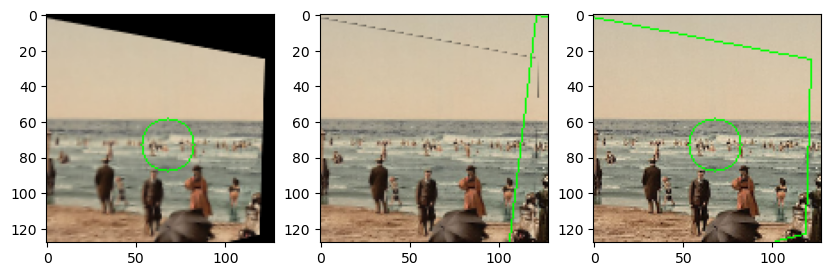

In [12]:
# 显示重叠
chic = 9
image1 = img1[chic].permute(1, 2,0).detach().cpu().numpy()
image0 = img2[chic].permute(1, 2,0).detach().cpu().numpy()
plt.figure(figsize=(10,10))
result = show_overlap(image1, image0, H[chic])
# cv2.imwrite("watch/result.png",result[:,:,::-1])

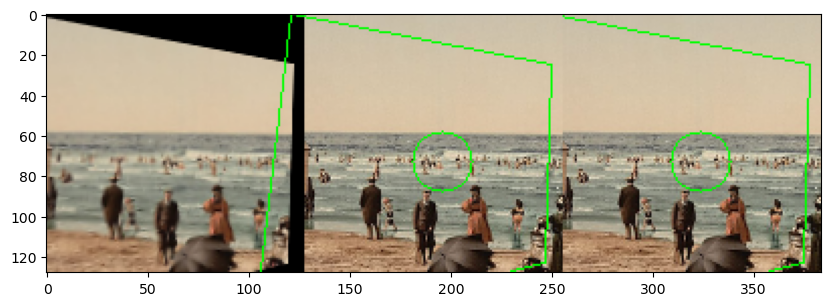

In [ ]:
result[0:image0.shape[0],image1.shape[1]:image0.shape[1] + image1.shape[1]] = image0 
h,w = image1.shape[0],image1.shape[1]
pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
center = np.float32( [w/2, h/2]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, H[chic]).reshape(-1, 2)
dst_center = cv2.perspectiveTransform(center, H[chic]).reshape(-1, 2)
# 加上偏移量
for i in range(4):
    dst[i][0] += w
dst_center[0][0] += w

cv2.polylines(result, [np.int32(dst)], True, (0, 255, 0), 1, cv2.LINE_AA)
cv2.circle(result,(int(dst_center[0][0]),int(dst_center[0][1])),15,(0,255,0),1)
plt.figure(figsize=(10,10))

plt.imshow(result.astype(np.uint8))